In [20]:
#Control time packages
import time
import os
import matplotlib.pyplot as plt
from numpy.core import machar
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from schwimmbad import MPIPool

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Autolens/ALMA/Data"#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition

boundary = {'ml': [0.5, 15], 'kappa_s': [0, 2], 'r_s': [5, 30], 'qDM': [0.1, 1], 'log_mbh':[7, 11],
                    'mag_shear': [0, 0.1], 'phi_shear': [0, 179], 'gamma': [0.95, 1.05]}

class Model(object):

    def __init__(self, mass_model, masked_image):
        self.mass_profile  = mass_model
        self.masked_image = masked_image

    def prior_transform(self, theta):
        ml, kappa_s, qDM, r_s, log_mbh, mag_shear, phi_shear, gamma = theta
        parsDic = {"ml": ml, "kappa_s": kappa_s, "r_s": r_s, "qDM": qDM,
                        "log_mbh":log_mbh, "mag_shear": mag_shear, "phi_shear": phi_shear, 
                        "gamma": gamma}
        for key in parsDic:
            parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
            
        return np.array(list(parsDic.values()))

    def log_likelihood(self, pars):
        quiet=False
        ml_model, kappa_s_model, r_s_model, qDM_model, log_mbh_model, mag_shear_model, phi_shear_model, gamma_model = pars
        
        ell_comps = al.convert.elliptical_comps_from(axis_ratio=qDM_model, phi=0.0) #Elliptical components in Pyautolens units
        eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s_model,elliptical_comps=ell_comps, scale_radius=r_s_model) #Set the analytical model
        self.mass_profile.Analytic_Model(eNFW)        #Include analytical model
        self.mass_profile.MGE_Updt_parameters(ml=ml_model, mbh=10**log_mbh_model, gamma=gamma_model)
        shear_comp_model = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_model, phi=phi_shear_model)
        #New lens model
        lens_galaxy = al.Galaxy(                                            
                redshift=self.mass_profile.z_l,
                mass=self.mass_profile,
                shear=al.mp.ExternalShear(elliptical_comps=shear_comp_model),
            )

        source_galaxy = al.Galaxy(
                redshift=self.mass_profile.z_s,
                pixelization=al.pix.Rectangular(shape=(40, 40)),
                regularization=al.reg.Constant(coefficient=1.5),
            )
        tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
        
        try:
            fit = al.FitImaging(masked_imaging=self.masked_image, tracer=tracer)

            log_evidence = fit.log_evidence

                
            if quiet is False:
                print("Lens Galaxy Configuration:")
                print("Log Likelihood_with_regularization:", fit.log_likelihood)
                print("Log Normalization", fit.log_likelihood)
                print("Log Evidence:", fit.log_evidence)
                print("#------------------------------------#")
                print(lens_galaxy)
                print("\n")


                aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))
                aplt.Inversion.reconstruction(fit.inversion)              


            return log_evidence, fit
        except:
            print("An exception ocurres in Pyautolens_log_likelihood().")
            return -np.inf
    
    def __call__(self, pars):
        return self.log_likelihood(pars)

def resume_dlogz(sampler):
        results = sampler.results
        logz_remain = np.max(sampler.live_logl) + results.logvol[-1]
        delta_logz = np.logaddexp(results.logz[-1], logz_remain) - results.logz[-1]
        
        return delta_logz

In [5]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.042                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/Alma_with_lens_center.fits",
        noise_map_path=f"{data_folder}/rms_noise_map.fits",
        psf_path=f"{data_folder}/Alma_psf_rot.fits",
        pixel_scales=0.02,
        image_hdu=1, noise_map_hdu=1, psf_hdu=1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/mask.fits", 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

#--------------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=0.85, phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                    surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                    mbh=mbh)
mass_profile.Analytic_Model(analytic_profile=eNFW)



#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.50),
)

print("Starting functions... \n")
start = time.time()
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

#aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Evidence:", fit.log_evidence)
print("Log Likelihood :", fit.log_likelihood)
print("Elapsed Time [s]:", (time.time() - start))

#Defing Model
#model = Model(mass_model=mass_profile, masked_image=masked_image)

Starting functions... 

Log Likelihood with Regularization: -1187977.181989322
Log Evidence: -1193202.8885808024
Log Likelihood : -1187976.9643100612
Elapsed Time [s]: 7.989161252975464


In [32]:
import pickle
with open(f'dynesty_lens.pickle','rb') as f:
    sample_load = pickle.load(f)
    
with open(f'dynesty_lens2.pickle','rb') as f:
    sample_load2 = pickle.load(f)
    
results1 = sample_load.results
results2 = sample_load2.results

results1.summary()
results2.summary()

Summary
nlive: 200
niter: 2124
ncall: 48756
eff(%):  4.767
logz: -115819.899 +/-  0.407
Summary
nlive: 120
niter: 894
ncall: 123086
eff(%):  0.824
logz: -133777.227 +/-  0.463


In [36]:
results = dyfunc.merge_runs([results1, results2])
from dynesty import plotting as dyplot
fig, axes = dyplot.runplot(results)

LinAlgError: singular matrix

In [59]:
from dynesty import utils as dyfunc
labels = ["ml", "kappa_s", "rs","qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean, cov

(array([3.39514502e+00, 3.49763098e-01, 6.27151649e+00, 1.32048944e-01,
        7.48925119e+00, 9.62606650e-02, 1.24485606e+02, 9.53419341e-01]),
 array([[4.94030928e-31, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.23507732e-31],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.000

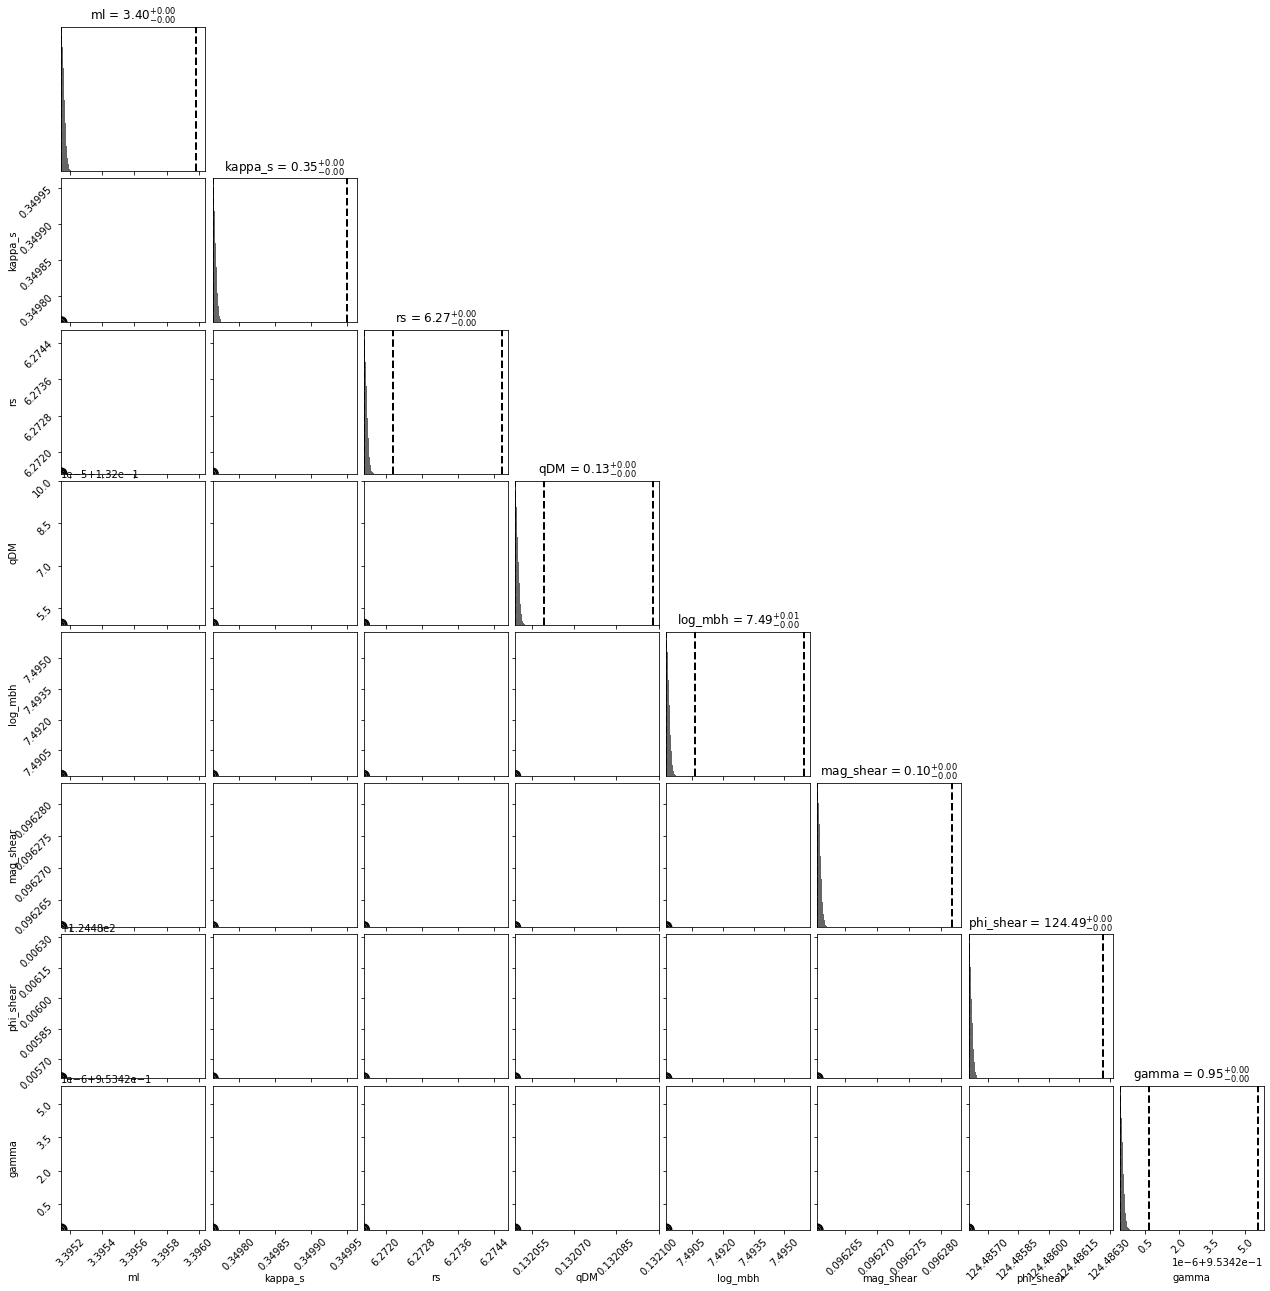

In [37]:
labels = ["ml", "kappa_s", "rs", "qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]
cfig, caxes = dyplot.cornerplot(results_sim,show_titles=True,labels=labels,
                               )

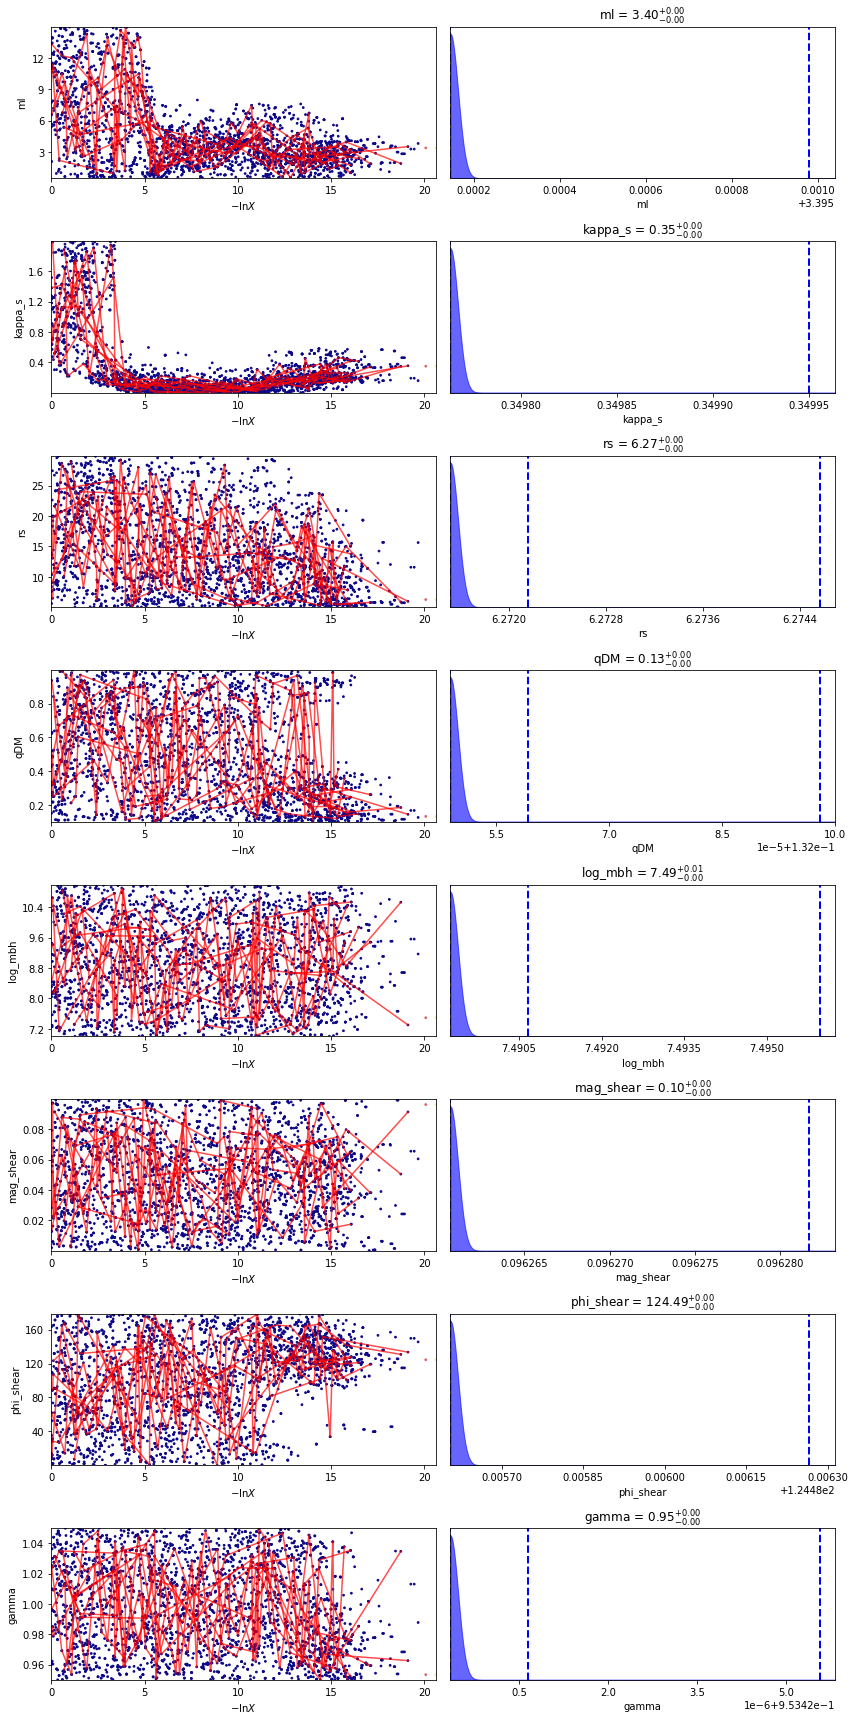

In [38]:
rfig, raxes = dyplot.traceplot(results_sim, labels=labels,
                               show_titles=True, connect=True, )
plt.tight_layout()

In [39]:
model = Model(mass_model=mass_profile, masked_image=masked_image)

Lens Galaxy Configuration:
Log Likelihood_with_regularization: -107278.63942019381
Log Normalization -107278.63942019381
Log Evidence: -115803.30913335797
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.9534193406892215
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.766708065059555)
axis_ratio: 0.13204894433567937
phi: 0.0
kappa_s: 0.34976309844716597
scale_radius: 6.271516493369299
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 3.3951450236161356
surf_dm: None
sigma_dm: None
qobs_dm:

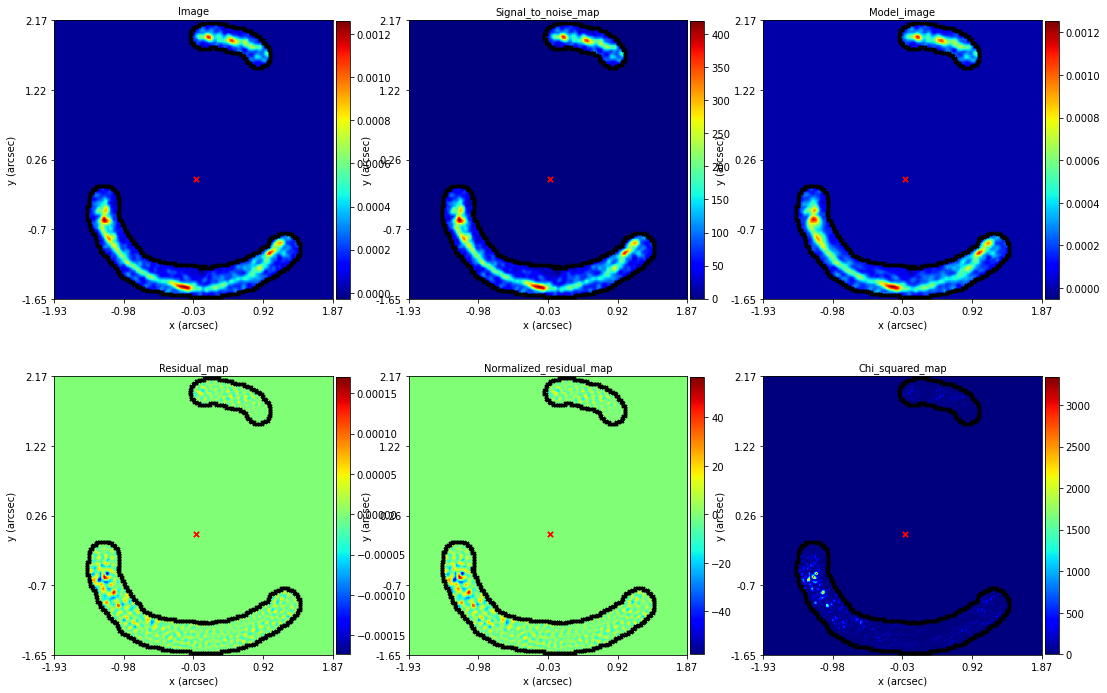

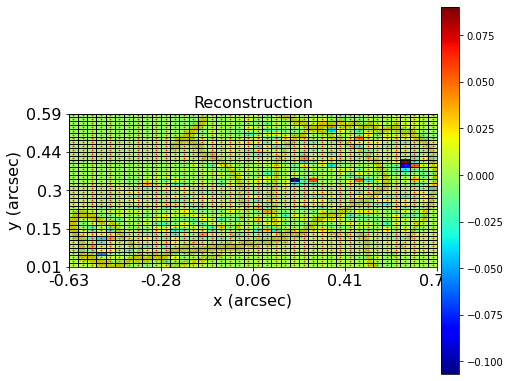

In [40]:
log_evi, fit_fun = model(mean)

In [42]:

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  cov = wsum / (wsum**2 - w2sum) * np.einsum('i,ij,ik', weights, dx, dx)
/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:111: RuntimeWarning: invalid value encountered in multiply
  cov = wsum / (wsum**2 - w2sum) * np.einsum('i,ij,ik', weights, dx, dx)


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -107278.63942019381
Log Normalization -107278.63942019381
Log Evidence: -115803.30913335797
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.9534193406892216
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.7667080650595549)
axis_ratio: 0.13204894433567943
phi: 0.0
kappa_s: 0.34976309844716597
scale_radius: 6.2715164933693
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 3.3951450236161356
surf_dm: None
sigma_dm: None
qobs_dm: 

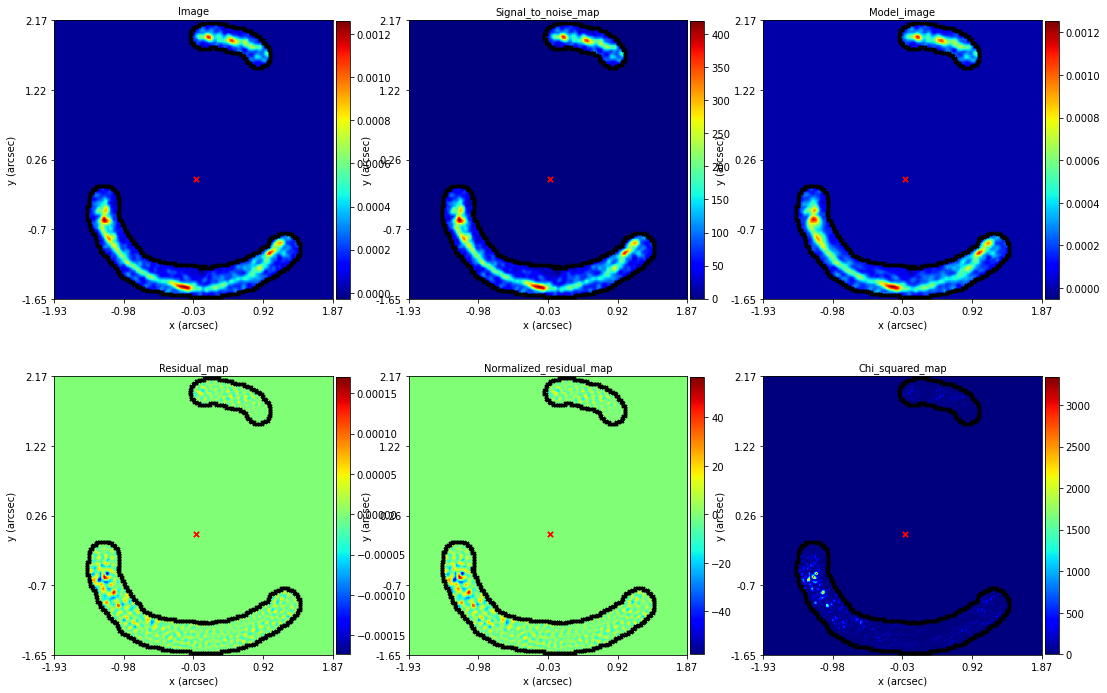

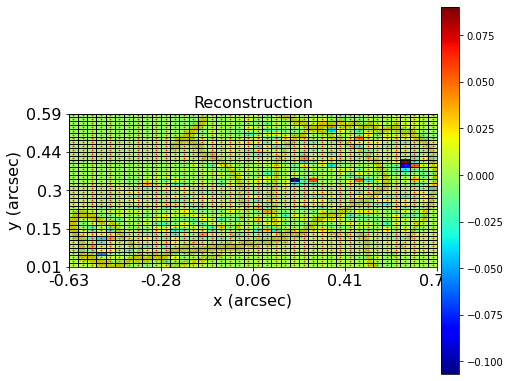

In [45]:
log_evi, fit_fun = model(mean)

In [50]:
results1.eff

4.76659282960046